In [5]:
# Zadanie 4
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score
import seaborn as sns

print("1. Wczytywanie danych")
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), random_state=42)
print(f"Liczba dokumentów: {len(newsgroups_train.data)}")
print(f"Liczba kategorii: {len(newsgroups_train.target_names)}")
print("Kategorie:", newsgroups_train.target_names)

1. Wczytywanie danych
Liczba dokumentów: 11314
Liczba kategorii: 20
Kategorie: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [6]:
# Tekst na wektory
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=3000,        
        min_df=2,                 
        max_df=0.8,                 
        stop_words='english',
        ngram_range=(1, 1),       
        use_idf=True,
        sublinear_tf=True         
    )),
    ('svd', TruncatedSVD(         
        n_components=100, 
        random_state=42,
        algorithm='randomized'    
    ))
])

X_transformed = pipeline.fit_transform(newsgroups_train.data)



In [16]:
# Liczenie silhouette scores dla różnych k 
silhouette_scores = []
wcss = []
k_range = range(2, 101)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters= kmeans.fit_predict(X_transformed)  
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_transformed, clusters)
    silhouette_scores.append(silhouette_avg)
    

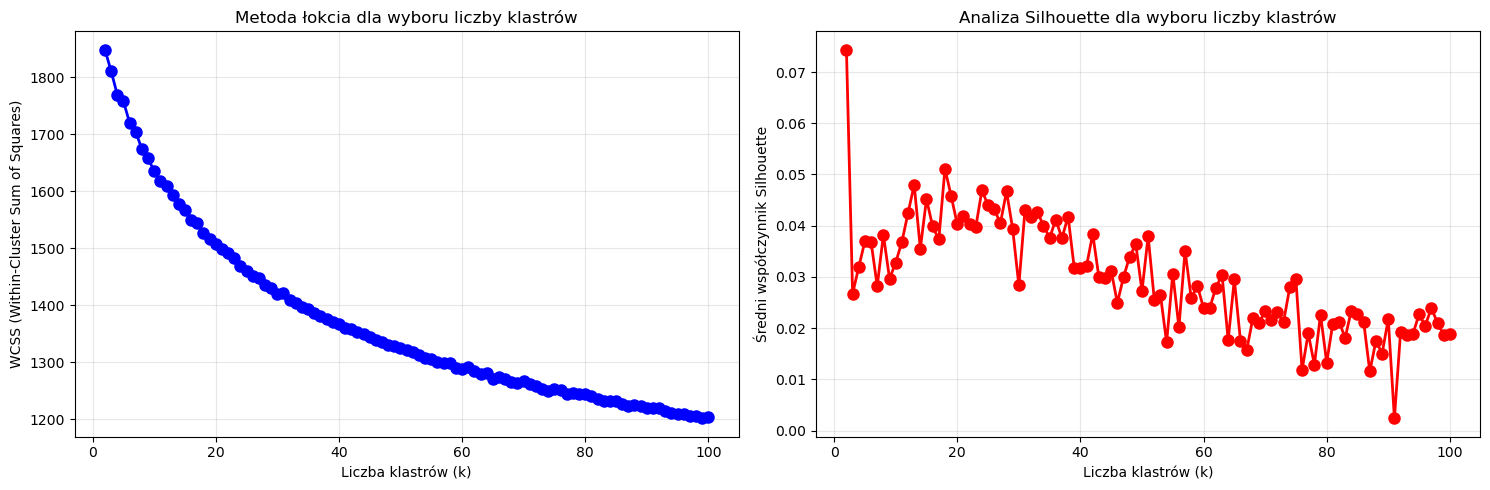

18


In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Metoda łokcia
ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Liczba klastrów (k)')
ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)')
ax1.set_title('Metoda łokcia dla wyboru liczby klastrów')
ax1.grid(True, alpha=0.3)

# Wykres silhouette
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Liczba klastrów (k)')
ax2.set_ylabel('Średni współczynnik Silhouette')
ax2.set_title('Analiza Silhouette dla wyboru liczby klastrów')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = k_range[np.argmax(silhouette_scores[1:]) + 1]
print(best_k)

In [21]:
# Redukcja wymiarowości
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_transformed)

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
X_2d = tsne.fit_transform(X_transformed)

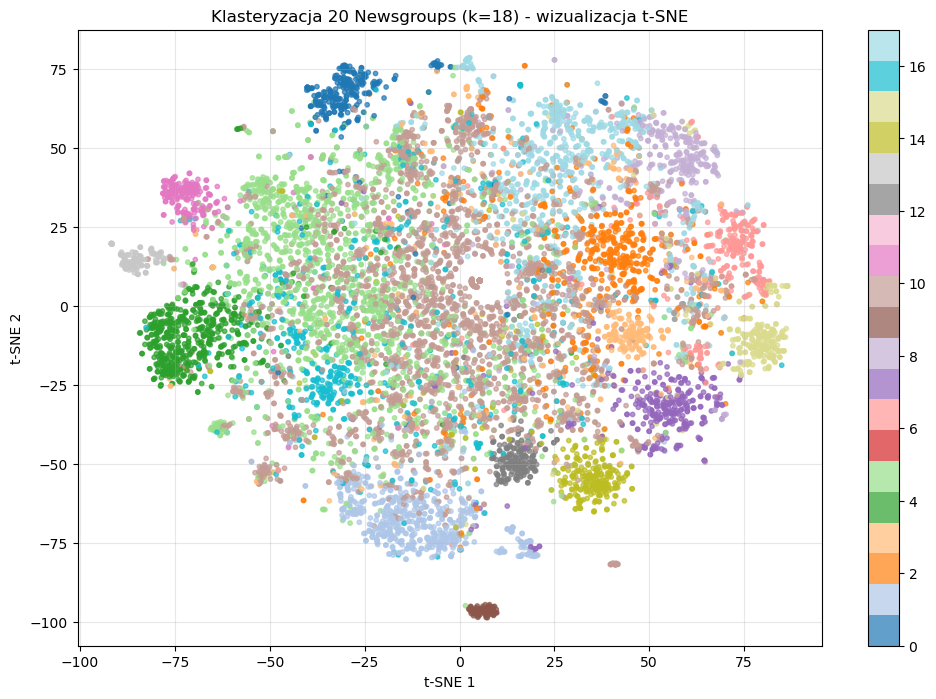

In [22]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
                     cmap='tab20', alpha=0.7, s=10)
plt.colorbar(scatter)
plt.title(f'Klasteryzacja 20 Newsgroups (k={best_k}) - wizualizacja t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# Pobieramy wektor cech
tfidf_vectorizer = pipeline.named_steps['tfidf']
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dla każdego klastra znajdź najbardziej charakterystyczne słowa
for cluster_id in range(best_k):
    print(f"\n{'='*50}")
    print(f"KLASTER {cluster_id}")
    print(f"{'='*50}")
    
    # Znajdujemy dokumenty w klastrze
    cluster_mask = (cluster_labels == cluster_id)
    cluster_docs = np.array(newsgroups_train.data)[cluster_mask]
    cluster_original_categories = newsgroups_train.target[cluster_mask]
    
    print(f"Liczba dokumentów w klastrze: {len(cluster_docs)}")
    
    # Najczęstsze oryginalne kategorie w klastrze
    if len(cluster_original_categories) > 0:
        unique_cats, counts = np.unique(cluster_original_categories, return_counts=True)
        top_categories = []
        for cat_id, count in zip(unique_cats, counts):
            if count > len(cluster_docs) * 0.1:  # Tylko kategorie z >10% dokumentów
                cat_name = newsgroups_train.target_names[cat_id]
                top_categories.append(f"{cat_name} ({count})")
        
        if top_categories:
            print("Dominujące oryginalne kategorie:", ", ".join(top_categories))
    
    # Znajdź najbardziej charakterystyczne słowa dla klastra
    cluster_centroid = kmeans.cluster_centers_[cluster_id]
    
    # Dla KernelPCA nie mamy bezpośredniego odwzorowania, więc użyjemy innej metody
    # Obliczmy średni wektor TF-IDF dla dokumentów w klastrze
    cluster_tfidf = tfidf_vectorizer.transform(cluster_docs)
    cluster_mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
    
    # Znajdź indeksy najważniejszych cech
    top_feature_indices = np.argsort(cluster_mean_tfidf)[-15:][::-1]
    top_features = [feature_names[i] for i in top_feature_indices if cluster_mean_tfidf[i] > 0]
    
    print("Charakterystyczne słowa:", ", ".join(top_features[:10]))
    


KLASTER 0
Liczba dokumentów w klastrze: 288
Dominujące oryginalne kategorie: sci.crypt (273)
Charakterystyczne słowa: key, encryption, clipper, chip, keys, escrow, government, secure, nsa, algorithm

KLASTER 1
Liczba dokumentów w klastrze: 632
Dominujące oryginalne kategorie: rec.sport.baseball (245), rec.sport.hockey (378)
Charakterystyczne słowa: game, team, year, games, season, players, play, hockey, league, win

KLASTER 2
Liczba dokumentów w klastrze: 560
Dominujące oryginalne kategorie: comp.graphics (90), comp.sys.ibm.pc.hardware (60), comp.sys.mac.hardware (72), comp.windows.x (64)
Charakterystyczne słowa: thanks, advance, mail, know, does, hi, help, info, looking, email

KLASTER 3
Liczba dokumentów w klastrze: 368
Charakterystyczne słowa: edu, university, cs, email, mail, internet, uiuc, cc, send, just

KLASTER 4
Liczba dokumentów w klastrze: 560
Dominujące oryginalne kategorie: alt.atheism (98), soc.religion.christian (340), talk.religion.misc (110)
Charakterystyczne słowa: g